In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
class Value:
    def __init__(self, data, _children=() , _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.grad = 0.0
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        # out.label = self.label + '+' + other.label
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        # out.label = self.label + '*' + other.label
        return out
    
    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data ** other,(self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
        
    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # out.label = f'tanh({self.label})'
        return out

    def exp(self):
        x = self.data
        out = Value(x, (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()
        
# a = Value(3.0, label='a')
# b = Value(-2.0, label='b')
# c = Value(5.0, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label ='d'
# f = Value(-2.0, label='f')
# L = d * f
# L.label = 'L'


In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(value):
        if value not in nodes:
            nodes.add(value)
            for child in value._prev:
                edges.add((child, value))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'TB'}) # LR = left to right
    
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # for any value in a grpahql create rectangular node for it
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (node.label, node.data, node.grad ),
                 shape='record')
        if node._op:
            dot.node(name = uid + node._op, label = node._op)
            dot.edge(uid + node._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
                


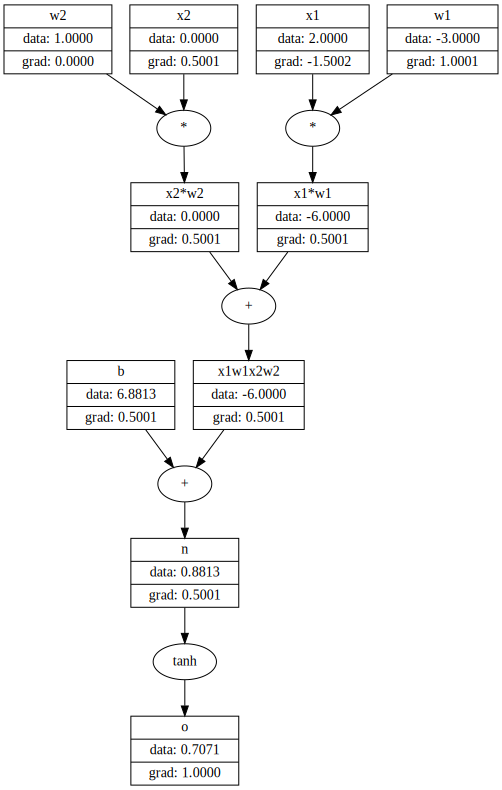

In [7]:
# input x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1  + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [5]:
import random

class Neuron:
    def __init__(self, nin):
            self.weights = [Value(random.uniform(-1, 1), label=f'w{i}') for i in range(nin)] 
            self.b = Value(random.uniform(-1, 1), label='b')

    def __call__(self, xs: list[Value]):
        z = zip(self.weights, xs)
        act = sum((wi*xi for wi, xi in z), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.b]
    
class Layer:
#     nin - number of inputs
#     nout - number of outputs
    def __init__(self, nin:int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x: list[Value]):
        outs = [n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()] 

class MLP:
    #     nin - number of inputs
    #     nouts - number of outputs(layer size) on each level
    def __init__(self, nin: int, nouts: list[int]):
        sz = [nin] + nouts
        self.layers:list[Layer] = []
        for i in range(len(nouts)):
            self.layers.append(Layer(sz[i], sz[i + 1]))
    
    def __call__(self, xs: list[float]):
        # xvalues = []
        xvalues = xs
        
        
        # for i, x in enumerate(xs):
        #     xvalues.append(Value(x, label=f'x{i}'))
        
        for layer in self.layers:
            xvalues = layer(xvalues)
        return xvalues
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]


In [6]:

class TrueNeuron:

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1), label=f'w{i}') for i in range(nin)]
        self.b = Value(0)

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class TrueLayer:

    def __init__(self, nin, nout):
        self.neurons = [TrueNeuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class TrueMLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [TrueLayer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
xs = [
    [2.0, 3.0, 1.0],
    [-3.0, -1.0, 1.0],
    [1.0, -1.0, 1.0],
    [-2.0, -1.0,7.0]
]
expected_ys = [-1.0, -1.0, 1.0, -1.0]

number_of_inputs = len(xs[0])
number_of_outputs_for_each_layer = [4, 4, 1]

In [8]:
mlp = MLP(len(xs[0]), number_of_outputs_for_each_layer)
# result = mlp(xs)[0]
# print(result)
# draw_dot(result).view()

In [9]:
# Forward pass
actual_ys = [mlp(x)[0] for x in xs]
print("actual: ", actual_ys)
loss: Value = sum((expected_y - actual_y)**2 for expected_y, actual_y in zip(expected_ys, actual_ys))
loss
print("loss: ", loss)

# zero grad
for p in mlp.parameters():
    p.grad = 0.0
# Backward pass
loss.backward()

for p in mlp.parameters():
    p.data += -0.01 * p.grad

actual:  [Value(data=-0.47182566801411413), Value(data=-0.7560729811251999), Value(data=-0.6413839134487775), Value(data=-0.9508860910390403)]
loss:  Value(data=3.0350218428877334)


In [10]:
loss: Value = sum((expected_y - actual_y)**2 for expected_y, actual_y in zip(expected_ys, actual_ys))
loss

Value(data=3.0350218428877334)

In [11]:
# Backward pass
loss.backward()

In [12]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [13]:
# draw_dot(loss).view()